In [15]:

from analyze import analyze_data
from utils import RequestData
import json
from datetime import datetime
from zoneinfo import ZoneInfo
import re
run_log_dir = "/mnt/network_drive/lrq/logs/logs_2025-08-20-14-40-12/run_0"
GRAN = "30s"
metrics_list = []
report_file_path = analyze_data(run_log_dir, metrics_list)
with open(report_file_path, 'r') as f:
    report = json.load(f)

loadgen_data = report['loadgen_data']
total_request_count = len(loadgen_data)
no_response_count = 0
error_count = 0
requests = []
for request_data in loadgen_data:
    if 'error' not in request_data.keys():
        request = RequestData.init_from_dict(request_data)
        requests.append(request)
        continue

    if request_data == {'error': 'No response!'}:
        no_response_count += 1
    else:
        error_count += 1
        print(request_data)

print(f"Total request: {total_request_count}, no response: {no_response_count}, error: {error_count}")
recv_kv_failed_requests = report['recv_failed_requests']
print(f"There are totally {len(recv_kv_failed_requests)} requests fall back to model forwarding!")

start_str = report.get('router_start_time', 'N/A')
end_str = report.get('router_end_time', 'N/A')
tz_sg = ZoneInfo("Asia/Singapore")
router_start_time = datetime.fromisoformat(start_str).replace(tzinfo=tz_sg).timestamp()
router_end_time = datetime.fromisoformat(end_str).replace(tzinfo=tz_sg).timestamp()
pattern = re.compile(r"^(\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}) Finished preparing http requests")
with open(f"{run_log_dir}/loadgen.err") as f:
    for line in f:
        m = pattern.match(line)
        if m:
            dt = datetime.strptime(m.group(1), "%Y/%m/%d %H:%M:%S").replace(tzinfo=tz_sg)
            break

first_request_sendtime = dt.timestamp() + 5
print(f"Router start time: {router_start_time}, end time: {router_end_time}")

QUERY_PROM is 0, skipping Prometheus startup.
Running Python app...
query_metrics_list: []
params_list: []
Total request: 120, no response: 0, error: 0
There are totally 0 requests fall back to model forwarding!
Router start time: 1755672046.856699, end time: 1755672561.348961


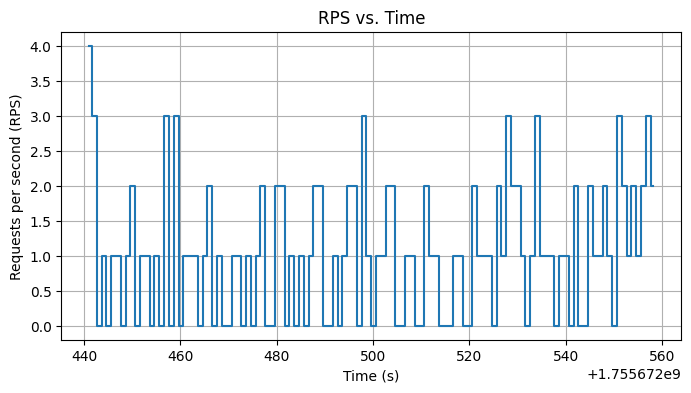

In [17]:
request_arrival_times = []
for request_data in loadgen_data:
    request_arrival_times.append(request_data['arrival_time'])

import numpy as np
import matplotlib.pyplot as plt

# Assume request_arrival_times is in seconds (floats or ints)
arrival_times = np.array(request_arrival_times)

# Choose bin size (e.g. 1 second)
bin_size = 1
min_t, max_t = arrival_times.min(), arrival_times.max()

# Create bins
bins = np.arange(min_t, max_t + bin_size, bin_size)

# Count how many requests fall in each bin
counts, edges = np.histogram(arrival_times, bins=bins)
counts = counts / bin_size  # Convert counts to requests per second (RPS)

# Compute the midpoints of bins for plotting
bin_centers = edges[:-1] + bin_size / 2.0

# Plot RPS vs time
plt.figure(figsize=(8, 4))
plt.plot(bin_centers, counts, drawstyle="steps-mid")
plt.xlabel("Time (s)")
plt.ylabel("Requests per second (RPS)")
plt.title("RPS vs. Time")
plt.grid(True)
plt.show()
    